In [1]:
!pip install -q underthesea
!pip install -q rouge-score
!pip install -q flash_attn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.9/20.9 MB 55.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 657.8/657.8 kB 26.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 32.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 42.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 26.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 11.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 13.7 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not c

# Import thư viện

In [2]:
import json
import os
import pandas as pd
import re
import string
import numpy as np
import pickle
import torch.nn as nn
from underthesea import word_tokenize, text_normalize
import random
from PIL import Image
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import spacy
from collections import Counter
from tqdm import tqdm
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from torch.utils.data import Dataset, DataLoader
import torch
import torchvision.models as models
from torchvision.models import resnet50, ResNet50_Weights
import torch.nn.functional as F
import math
import logging
import time
from torch.optim import AdamW
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from rouge_score import rouge_scorer
from transformers import AutoModel, CLIPImageProcessor

2025-05-18 03:30:37.140166: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747539037.451678      13 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747539037.539953      13 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Import dữ liệu

In [3]:
def read_json(path):
    with open(path, 'r') as f:
        data = json.load(f)
        images_list = data['annotations']
        return pd.DataFrame(images_list)

In [4]:
df_train = read_json("/kaggle/input/vitextvqa/ViTextVQA_json/ViTextVQA_train.json")
df_test = read_json("/kaggle/input/testdataset-cv/data_test_cv/My_ViTextVQA_test.json")
df_val = read_json("/kaggle/input/vitextvqa/ViTextVQA_json/ViTextVQA_dev.json")
# df_train = df_train.iloc[0:10]
df = pd.concat([df_train, df_val])
df

,id,image_id,question,answers
0,1,0,quán ăn này bán những món gì ?,"[mì quảng , bún bò huế]"
1,2,0,quán ăn này bán mì gì ?,[mì quảng]
2,3,0,quán ăn gì bán bún gì ?,[bún bò huế]
3,4,0,quán ăn này địa chỉ ở đâu ?,"[13a trần quốc thảo , phường 7 , quận 3]"
4,5,1,tiệm trong ảnh là tiệm gì ?,[sửa xe]
...,...,...,...,...
5150,50295,16741,bảng này do công ty tnhh kỹ thuật nào sản xuất ?,[pmit]
5151,50296,16741,công ty pmit là công ty gì ?,[tnhh kỹ thuật]
5152,50297,16741,email của công ty pmit là gì ?,[pmit . general@gmail . com]
5153,50298,16741,số điện thoại của công ty pmit là gì ?,[0226 532544]


In [5]:
root_dir = "/kaggle/input/vitextvqa/data_gen/data_gen"
df_gen = pd.DataFrame()
for path in os.listdir(root_dir):
  df_temp = pd.read_csv(os.path.join(root_dir, path))
  df_gen = pd.concat([df_temp, df_gen])
df_gen

,id,image_id,question,answers
0,956,956,Ảnh nhà thờ này được tìm thấy ở đâu?,['dân trí']
1,956,956,Nguồn gốc của tấm ảnh chụp nhà thờ này là gì?,['dân trí']
2,957,957,Quyển sách này có tên gọi là gì?,['ánh sáng vô hình']
3,957,957,Tên gọi của cuốn sách này là như thế nào?,['ánh sáng vô hình']
4,957,957,Ai là người viết cuốn sách này?,['anthont doerr']
...,...,...,...,...
6960,11213,11213,Huy Hùng Phát mua lại những mặt hàng nào?,['xe cũ giá cao']
6961,11213,11213,Những loại hàng hóa nào được cửa hàng Huy Hùng...,['xe cũ giá cao']
6962,11226,11226,Ảnh này được lấy từ đâu?,['traveloka']
6963,11226,11226,Ai là người tạo ra bức ảnh này?,['traveloka']


# Xử lý data

In [6]:
def format_image(root_dir, df_1):
    df_1["path"] = df_1['image_id'].apply(lambda x: os.path.join(root_dir, str(x) + ".jpg"))
    df_1 = df_1.dropna(subset=['question','answers']).copy()
    df_1['question'] = df_1['question'].astype(str)
    df_1['answers'] = df_1['answers'].astype(str)
    df_1 = df_1.drop(["id"], axis = 1)
    df_1.reset_index(drop=True, inplace=True)
    return df_1

In [7]:
root_dir = '/kaggle/input/vitextvqa/ViTextVQA_images/st_images'
root_dir_test = "/kaggle/input/testdataset-cv/data_test_cv/image"
df = format_image(root_dir, df)
df_gen = format_image(root_dir, df_gen)
df_test = format_image(root_dir_test, df_test)
df

,image_id,question,answers,path
0,0,quán ăn này bán những món gì ?,"['mì quảng , bún bò huế']",/kaggle/input/vitextvqa/ViTextVQA_images/st_im...
1,0,quán ăn này bán mì gì ?,['mì quảng'],/kaggle/input/vitextvqa/ViTextVQA_images/st_im...
2,0,quán ăn gì bán bún gì ?,['bún bò huế'],/kaggle/input/vitextvqa/ViTextVQA_images/st_im...
3,0,quán ăn này địa chỉ ở đâu ?,"['13a trần quốc thảo , phường 7 , quận 3']",/kaggle/input/vitextvqa/ViTextVQA_images/st_im...
4,1,tiệm trong ảnh là tiệm gì ?,['sửa xe'],/kaggle/input/vitextvqa/ViTextVQA_images/st_im...
...,...,...,...,...
40309,16741,bảng này do công ty tnhh kỹ thuật nào sản xuất ?,['pmit'],/kaggle/input/vitextvqa/ViTextVQA_images/st_im...
40310,16741,công ty pmit là công ty gì ?,['tnhh kỹ thuật'],/kaggle/input/vitextvqa/ViTextVQA_images/st_im...
40311,16741,email của công ty pmit là gì ?,['pmit . general@gmail . com'],/kaggle/input/vitextvqa/ViTextVQA_images/st_im...
40312,16741,số điện thoại của công ty pmit là gì ?,['0226 532544'],/kaggle/input/vitextvqa/ViTextVQA_images/st_im...


In [8]:
df_test

,image_id,question,answers,path
0,IMG_0,số điện thoại của cửa hàng là bao nhiêu ?,['0562 000 100'],/kaggle/input/testdataset-cv/data_test_cv/imag...
1,IMG_0,địa chỉ website của của hàng là gì ?,['burgerpapa . com'],/kaggle/input/testdataset-cv/data_test_cv/imag...
2,IMG_0,tên cửa hàng là gì ?,['burger papa'],/kaggle/input/testdataset-cv/data_test_cv/imag...
3,IMG_0,tên cửa hàng bán món gì ?,['burger - gà rán - taco'],/kaggle/input/testdataset-cv/data_test_cv/imag...
4,IMG_1,tên của cửa tiệm này là gì ?,['bánh mì pewpew'],/kaggle/input/testdataset-cv/data_test_cv/imag...
...,...,...,...,...
95,IMG_45,dặc điểm của loài động vật trên bảng là gì ?,"['hình dạng giống kỳ đà , thường có màu xanh ....",/kaggle/input/testdataset-cv/data_test_cv/imag...
96,IMG_47,đây là hội nghị gì ?,['khoa học cấp khoa'],/kaggle/input/testdataset-cv/data_test_cv/imag...
97,IMG_47,hội nghị này tổ chức ai ?,"['khoa công nghệ thông tin , đại học công nghi...",/kaggle/input/testdataset-cv/data_test_cv/imag...
98,IMG_47,hội nghị này tổ chức vào thời gian nào ?,['15 tháng 12 năm 2024'],/kaggle/input/testdataset-cv/data_test_cv/imag...


In [9]:
print("NaN trong df:")
print(df.isna().sum())
print("\nNaN trong df_gen:")
print(df_gen.isna().sum())

NaN trong df:
image_id    0
question    0
answers     0
path        0
dtype: int64

NaN trong df_gen:
image_id    0
question    0
answers     0
path        0
dtype: int64


# Số dòng dữ liệu

In [10]:
print(f"Số data gốc: {len(df)}")
print(f"Số data tạo ra: {len(df_gen)}")

Số data gốc: 40314
Số data tạo ra: 25741


# So sánh độ tương đồng

In [11]:
def calculate_similarity(text1, text2):
    vectorizer = TfidfVectorizer()
    tfidf_matrix = vectorizer.fit_transform([text1, text2])
    return cosine_similarity(tfidf_matrix[0], tfidf_matrix[1])[0][0]

In [12]:
# Xử lý dữ liệu
df_1 = df.copy()
df_gen_filtered = df_gen.copy()
df_gen_filtered['similarity'] = np.nan
mask = pd.Series(False, index=df_gen.index)  # Mặc định bỏ tất cả

# Duyệt qua từng dòng trong df_gen với tqdm
for idx in tqdm(df_gen.index, desc="Xử lý các dòng trong df_gen"):
    question_gen = df_gen.loc[idx, 'question']
    answer_gen = df_gen.loc[idx, 'answers']
    
    # Kiểm tra xem câu hỏi hoặc câu trả lời có tồn tại trong df_1 không
    question_exists = question_gen in df_1['question'].values
    answer_exists = answer_gen in df_1['answers'].values
    
    if question_exists or answer_exists:
        if question_exists:
            # Nếu câu hỏi tồn tại, so sánh câu trả lời
            matched_row = df_1[df_1['question'] == question_gen].iloc[0]
            text_gen = answer_gen
            text_df1 = matched_row['answers']
        else:
            # Nếu câu trả lời tồn tại, so sánh câu hỏi
            matched_row = df_1[df_1['answers'] == answer_gen].iloc[0]
            text_gen = question_gen
            text_df1 = matched_row['question']
        
        similarity = calculate_similarity(text_gen, text_df1)
        df_gen.loc[idx, 'similarity'] = similarity
        
        # Đánh dấu để lọc df_gen_filtered
        if similarity > 0.5:
            mask[idx] = True

# Tạo df_gen_filtered chứa các dòng có độ tương đồng > 0.6
df_gen_filtered = df_gen[mask]

# In số lượng dòng trước và sau khi lọc
print(f"Số dòng trong df_gen ban đầu: {len(df_gen)}")
print(f"Số dòng trong df_gen_filtered: {len(df_gen_filtered)}")

Xử lý các dòng trong df_gen: 100%|██████████| 25741/25741 [04:27<00:00, 96.40it/s]

Số dòng trong df_gen ban đầu: 25741
Số dòng trong df_gen_filtered: 3709


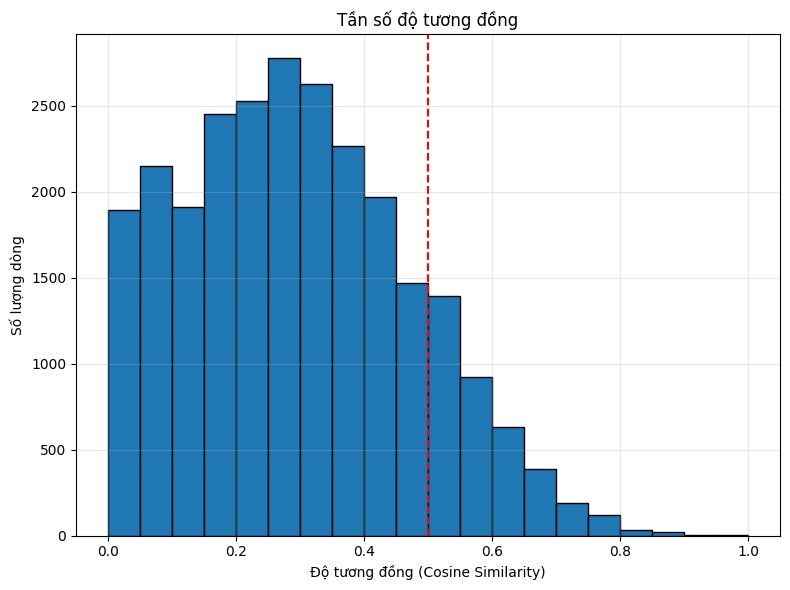

In [13]:
# Vẽ biểu đồ tần số độ tương đồng
plt.figure(figsize=(8, 6))
plt.hist(df_gen['similarity'], bins=20, color='#1f77b4', edgecolor='black')
plt.axvline(x=0.5, color='red', linestyle='--', label='Ngưỡng 0.5')  # Thêm đường chặn
plt.title('Tần số độ tương đồng')
plt.xlabel('Độ tương đồng (Cosine Similarity)')
plt.ylabel('Số lượng dòng')
plt.grid(True, alpha=0.3)
plt.tight_layout()

In [14]:
df_gen_filtered = df_gen_filtered.drop(['similarity'], axis = 1)
df_all = pd.concat([df, df_gen_filtered])
df_all

,image_id,question,answers,path
0,0,quán ăn này bán những món gì ?,"['mì quảng , bún bò huế']",/kaggle/input/vitextvqa/ViTextVQA_images/st_im...
1,0,quán ăn này bán mì gì ?,['mì quảng'],/kaggle/input/vitextvqa/ViTextVQA_images/st_im...
2,0,quán ăn gì bán bún gì ?,['bún bò huế'],/kaggle/input/vitextvqa/ViTextVQA_images/st_im...
3,0,quán ăn này địa chỉ ở đâu ?,"['13a trần quốc thảo , phường 7 , quận 3']",/kaggle/input/vitextvqa/ViTextVQA_images/st_im...
4,1,tiệm trong ảnh là tiệm gì ?,['sửa xe'],/kaggle/input/vitextvqa/ViTextVQA_images/st_im...
...,...,...,...,...
25703,11151,Cuốn sách này do ai sáng tác?,['nguyễn minh tuấn'],/kaggle/input/vitextvqa/ViTextVQA_images/st_im...
25720,11205,"Bên tay phải của người phụ nữ mặc áo cam, dòng...",['hải dương quê hương của vải thiều việt n'],/kaggle/input/vitextvqa/ViTextVQA_images/st_im...
25721,11205,Dòng chữ màu xanh nằm phía bên phải của người ...,['hải dương quê hương của vải thiều việt n'],/kaggle/input/vitextvqa/ViTextVQA_images/st_im...
25732,11213,Số liên lạc của cửa hàng Huy Hùng Phát là bao ...,['096 991 5445'],/kaggle/input/vitextvqa/ViTextVQA_images/st_im...


In [15]:
def normalize_text(text):
    clean_text = text.lower()

    replacements = {
        "[": "",
        "]": ""
    }

    for old, new in replacements.items():
        clean_text = clean_text.replace(old, new)

    # Xóa ký tự đặc biệt VD (&nbsp;)
    clean_text = re.sub(r'&\S+;', ' ', clean_text)

    # Xóa emoji
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"
                               u"\U0001F300-\U0001F5FF"
                               u"\U0001F680-\U0001F6FF"
                               u"\U0001F1E0-\U0001F1FF"
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               u"\U0001f926-\U0001f937"
                               u'\U00010000-\U0010ffff'
                               u"\u200d"
                               u"\u2640-\u2642"
                               u"\u2600-\u2B55"
                               u"\u23cf"
                               u"\u23e9"
                               u"\u231a"
                               u"\u3030"
                               u"\ufe0f"
                               "]+", flags=re.UNICODE)
    clean_text = re.sub(emoji_pattern, " ", clean_text)

    # Xóa ký tự đặc biệt không gõ được
    special_chars = ["“", "”", "…", "•", "–", "’", " ️", "✅", "✓", " ̂́ ̃ ̣̂ ", "‘", "●", "‒", "➤",
                     "★", "ღ", "✪", "‎", "➦", "×", "", "✿", "☆", "◤", "◕", "❁", "‿",
                     "❀", "■", "█", "☛", "⑴⒪⑵⑵⑴⑺", "►", "°", "»", "ø", "➽", "", "✧", "✽", "*",
                     "➫", "【", "】", "⇒", "卐", "♛", "±", "∞", "②", "⑥", "①", "⑦", "➋", "➊", "➌",
                     "✓", "™", "®", "", "'"]
    for char in special_chars:
        clean_text = clean_text.replace(char, " ")

    # # Bỏ các ký tự đặc biệt (dấu câu)
    # clean_text = ''.join(' ' if char in string.punctuation else char for char in clean_text)

    # Loại bỏ khoảng trắng thừa
    clean_text = re.sub(r"\s+", " ", clean_text)
    clean_text = re.sub(r"^[\s]", "", clean_text)
    clean_text = re.sub(r"[\s]$", "", clean_text)

    # Đảm bảo dấu ở đúng chữ (ví dụ: oà, uý)
    clean_text = text_normalize(clean_text)

    # Tách câu thành từ
    clean_text = word_tokenize(clean_text, format="text")

    return clean_text

def apply_normalize_text_to_dataframe(df, columns):
    for col in columns:
        df[col] = df[col].apply(lambda x: normalize_text(str(x)))
    return df

In [16]:
columns_to_process = ['question', 'answers']
df_all = apply_normalize_text_to_dataframe(df_all, columns_to_process)
df_test = apply_normalize_text_to_dataframe(df_test, columns_to_process)
df_all

,image_id,question,answers,path
0,0,quán ăn này bán những món gì ?,"mì quảng , bún_bò huế",/kaggle/input/vitextvqa/ViTextVQA_images/st_im...
1,0,quán ăn này bán mì gì ?,mì quảng,/kaggle/input/vitextvqa/ViTextVQA_images/st_im...
2,0,quán ăn gì bán bún gì ?,bún bò huế,/kaggle/input/vitextvqa/ViTextVQA_images/st_im...
3,0,quán ăn này địa_chỉ ở đâu ?,"13 a_trần quốc_thảo , phường 7 , quận 3",/kaggle/input/vitextvqa/ViTextVQA_images/st_im...
4,1,tiệm trong ảnh là tiệm gì ?,sửa xe,/kaggle/input/vitextvqa/ViTextVQA_images/st_im...
...,...,...,...,...
25703,11151,cuốn sách này do ai sáng_tác ?,nguyễn_minh_tuấn,/kaggle/input/vitextvqa/ViTextVQA_images/st_im...
25720,11205,"bên tay_phải của người phụ_nữ mặc áo_cam , dòn...",hải_dương quê_hương của vải thiều việt n,/kaggle/input/vitextvqa/ViTextVQA_images/st_im...
25721,11205,dòng chữ màu xanh nằm phía bên phải của người ...,hải_dương quê_hương của vải thiều việt n,/kaggle/input/vitextvqa/ViTextVQA_images/st_im...
25732,11213,số liên_lạc của cửa_hàng huy_hùng phát là bao_...,096 991 5445,/kaggle/input/vitextvqa/ViTextVQA_images/st_im...


# Trực quan hóa dữ liệu

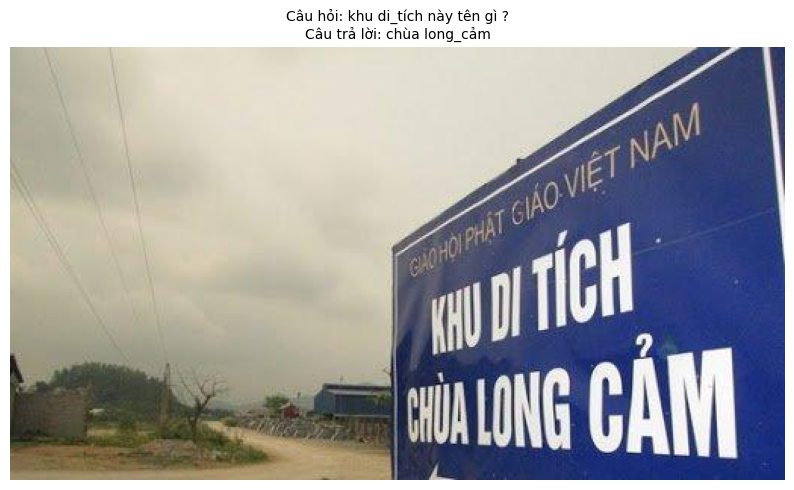

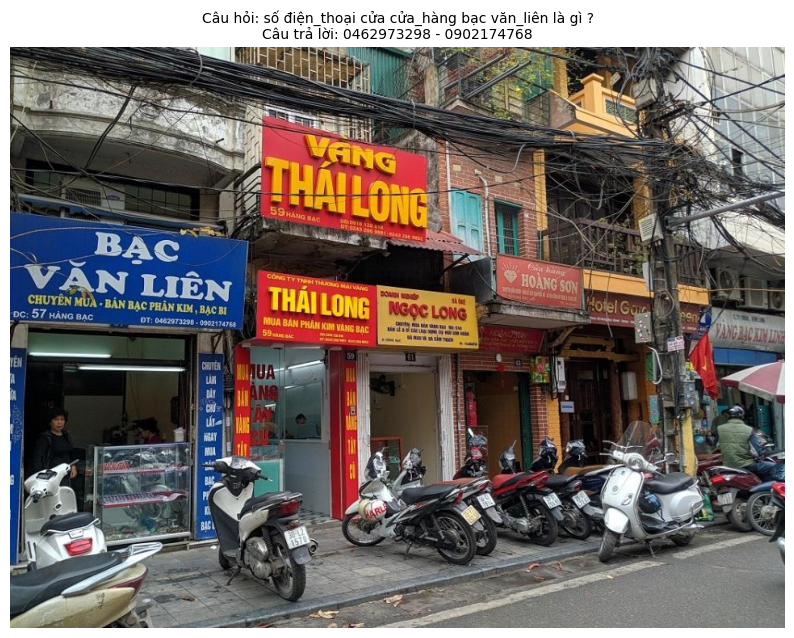

In [17]:
samples = df_all.sample(n=random.randint(2, min(2, len(df_all)))).reset_index(drop=True)

for i, row in samples.iterrows():
    image = row['path']
    question = row['question']
    answer = row['answers']

    try:
        # Mở và hiển thị hình ảnh
        img = Image.open(image)

        plt.figure(figsize=(10, 10))
        plt.imshow(img)
        plt.title(f"Câu hỏi: {question}\nCâu trả lời: {answer}", fontsize=10)
        plt.axis('off')  # Ẩn trục để hiển thị gọn gàng hơn
        plt.show()
    except FileNotFoundError:
        print(f"Không tìm thấy hình ảnh: {image}")
    except Exception as e:
        print(f"Lỗi khi tải hình ảnh {image}: {e}")

In [18]:
def get_sentence_length(text):
    if not isinstance(text, str):
        return 0
    tokens = word_tokenize(text)
    return len(tokens)

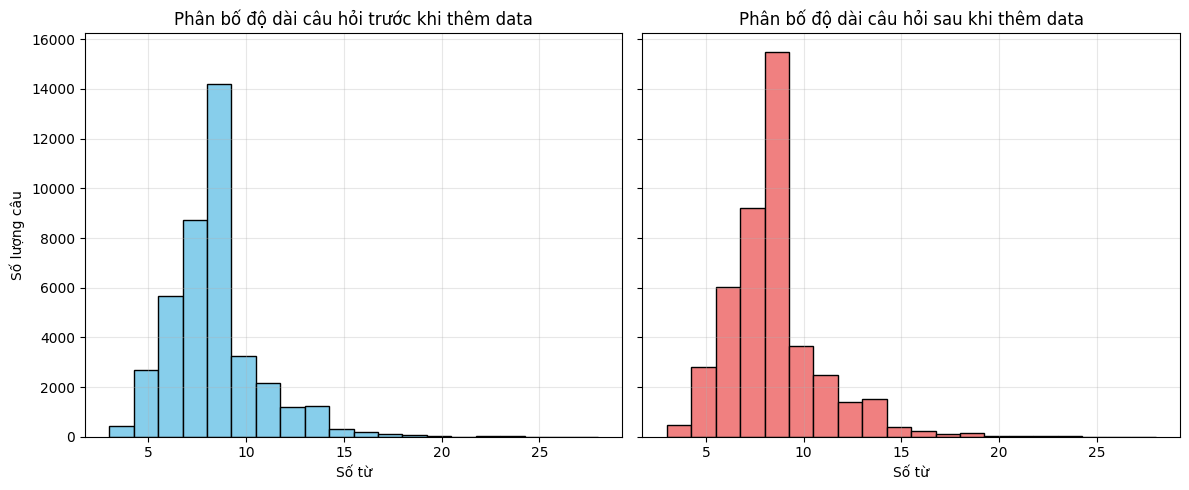

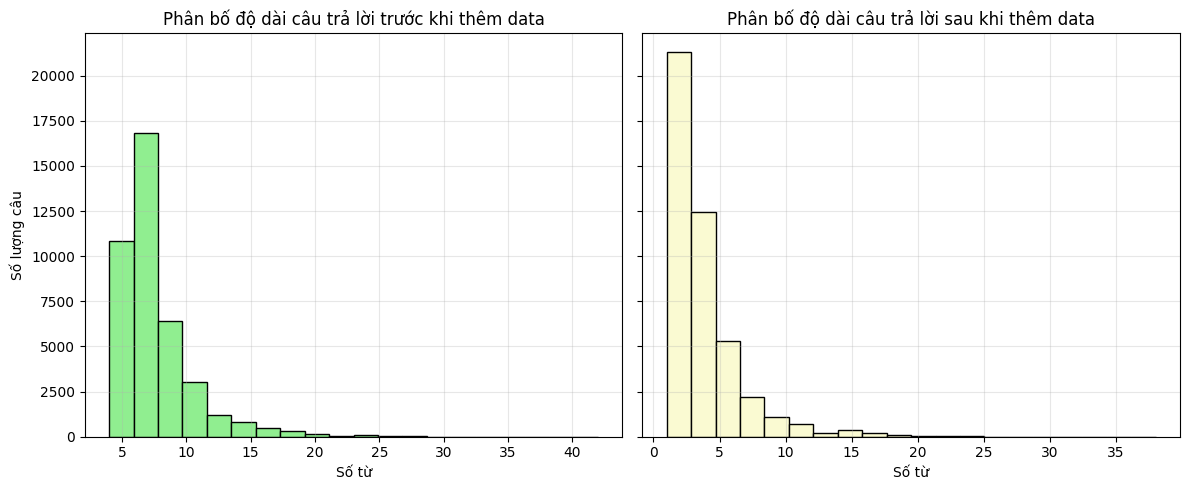

In [19]:
question_lengths_df = df['question'].apply(get_sentence_length).tolist()
answer_lengths_df = df['answers'].apply(get_sentence_length).tolist()
question_lengths_df_all = df_all['question'].apply(get_sentence_length).tolist()
answer_lengths_df_all = df_all['answers'].apply(get_sentence_length).tolist()

# Hình 1: Phân bố độ dài câu hỏi
fig1, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

# Biểu đồ 1: Độ dài câu hỏi trong df
ax1.hist(question_lengths_df, bins=20, color='skyblue', edgecolor='black')
ax1.set_title('Phân bố độ dài câu hỏi trước khi thêm data')
ax1.set_xlabel('Số từ')
ax1.set_ylabel('Số lượng câu')
ax1.grid(True, alpha=0.3)

# Biểu đồ 2: Độ dài câu hỏi trong df_all
ax2.hist(question_lengths_df_all, bins=20, color='lightcoral', edgecolor='black')
ax2.set_title('Phân bố độ dài câu hỏi sau khi thêm data')
ax2.set_xlabel('Số từ')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Hình 2: Phân bố độ dài câu trả lời
fig2, (ax3, ax4) = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

# Biểu đồ 3: Độ dài câu trả lời trong df
ax3.hist(answer_lengths_df, bins=20, color='lightgreen', edgecolor='black')
ax3.set_title('Phân bố độ dài câu trả lời trước khi thêm data')
ax3.set_xlabel('Số từ')
ax3.set_ylabel('Số lượng câu')
ax3.grid(True, alpha=0.3)

# Biểu đồ 4: Độ dài câu trả lời trong df_all
ax4.hist(answer_lengths_df_all, bins=20, color='lightgoldenrodyellow', edgecolor='black')
ax4.set_title('Phân bố độ dài câu trả lời sau khi thêm data')
ax4.set_xlabel('Số từ')
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Tạo tập từ vựng

In [20]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),

    #Thêm 1 vài bước xử lý ảnh để đa dạng hóa dữ liệu - Data Augmentation
    transforms.RandomRotation(30),  # Xoay ảnh ngẫu nhiên trong khoảng ±30 độ
    transforms.RandomHorizontalFlip(),  # Lật ngang ngẫu nhiên
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Điều chỉnh độ sáng, độ tương phản
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) 
])

In [21]:
nlp = spacy.load("en_core_web_sm")

In [22]:
#Tokenizer sử dụng spacy
def spacy_tokenizer(text):
    tokens = []
    for token in nlp(text):
        if not token.is_punct and not token.is_space: # Nếu không phải là dấu câu hoặc là khoảng trống thì thêm vào tokens
            tokens.append(token.text.lower())
    return tokens # Trả về mảng có chứa các chữ trong câu

In [23]:
#Xây dựng vocab cho bài toán
def build_vocab(texts, min_freq = 1):
    """
    texts: danh sách các câu hỏi hoặc trả lời được đưa vào
    min_freq: Tần suất tối thiểu 1 chữ xuất hiện để đưa vào vocab
    """
    counter = Counter()
    for text in texts:
        counter.update(spacy_tokenizer(text)) #Counter để đếm xem 1 chữ xuất hiện bao nhiêu lần
    # print(counter)

    vocab = {}
    vocab["<unk>"] = 0  # Token unknown
    vocab["<pad>"] = 1  # Token padding
    vocab["<sos>"] = 2  # Start of sentence
    vocab["<eos>"] = 3  # End of sentence
    
    index = 4 #Bắt đầu từ 2 do 0 với 1 dành cho <UNK>, <PAD>
    for word, freq in counter.items():
        if freq >= min_freq:
            vocab[word] = index
            index += 1
    # print(vocab)
    return vocab

In [24]:
vocab_questions = build_vocab(df_all['question'])
vocab_answers = build_vocab(df_all['answers'])

In [25]:
# Kiểm tra một số từ trong vocab
print("Sample vocab from questions:")
for word, index in list(vocab_questions.items())[:10]:  # Hiển thị 10 từ đầu tiên
    print(f"{word}: {index}")

print("\nSample vocab from answers:")
for word, index in list(vocab_answers.items())[:10]:  # Hiển thị 10 từ đầu tiên
    print(f"{word}: {index}")

Sample vocab from questions:
<unk>: 0
<pad>: 1
<sos>: 2
<eos>: 3
quán: 4
ăn: 5
này: 6
bán: 7
những: 8
món: 9

Sample vocab from answers:
<unk>: 0
<pad>: 1
<sos>: 2
<eos>: 3
mì: 4
quảng: 5
bún_bò: 6
huế: 7
bún: 8
bò: 9


In [26]:
# Lấy kích thước của các vocab
questions_vocab_size = len(vocab_questions)
answers_vocab_size = len(vocab_answers)
questions_vocab_size

9638

In [27]:
idx2word_answers = {idx: word for word, idx in vocab_answers.items()} #Đây sẽ là phần đối chiếu từ 1 indice sang 1 từ

In [28]:
# Kiểm tra một số từ trong vocab
print("\nSample vocab from answers:")
for word, index in list(idx2word_answers.items())[:10]:  # Hiển thị 10 từ đầu tiên
    print(f"{word}: {index}")


Sample vocab from answers:
0: <unk>
1: <pad>
2: <sos>
3: <eos>
4: mì
5: quảng
6: bún_bò
7: huế
8: bún
9: bò


In [29]:
#Hàm sẽ biến đổi 1 tensor chứa các indice chuyển sang thành 1 câu dựa trên idx2word_answers
def decode_answer(tensor, vocab_dict):
    return " ".join([vocab_dict[idx] for idx in tensor if idx not in {0, 1}])

In [30]:
def get_max_len(texts):
    max_len = 0
    for text in texts:
        tokens = spacy_tokenizer(text)
        if len(tokens) > max_len:
            max_len = len(tokens)
    return max_len

In [31]:
# len_max_question = get_max_len(df_train['question'])
# len_max_answer = get_max_len(df_train['response'])

len_max_question = 14
len_max_answer = 10

In [32]:
with open("/kaggle/input/extract-feature-cv/internvit_features.pkl", "rb") as f:
    features = pickle.load(f)

In [33]:
features["0"]

array([[-4.27391  , -5.2458024, -4.3457255, ..., -3.5121388, -1.3363734,
         4.4184346]], dtype=float32)

In [34]:
features["0"].shape

(1, 1024)

In [35]:
class VQAModel(nn.Module):
    def __init__(self, feature_dim, question_vocab_size, answer_vocab_size, embed_dim, hidden_dim, max_answer_len):
        super(VQAModel, self).__init__()
        self.max_answer_len = max_answer_len
        
        # Image feature encoder
        self.image_fc = nn.Linear(feature_dim, hidden_dim)
        
        # Question encoder
        self.question_embed = nn.Embedding(question_vocab_size, embed_dim)
        self.question_lstm = nn.LSTM(embed_dim, hidden_dim, batch_first=True)
        
        # Decoder
        self.decoder_lstm = nn.LSTM(hidden_dim * 2, hidden_dim, batch_first=True)
        self.decoder_fc = nn.Linear(hidden_dim, answer_vocab_size)
        
    def forward(self, image_features, questions, answers=None):
        # Image features: (batch_size, 1, feature_dim) -> (batch_size, feature_dim)
        image_features = image_features.squeeze(1)  # Loại bỏ chiều 1
        image_encoded = F.relu(self.image_fc(image_features))  # (batch_size, hidden_dim)
        
        # Question encoding
        question_embedded = self.question_embed(questions)  # (batch_size, max_question_len, embed_dim)
        _, (question_hidden, _) = self.question_lstm(question_embedded)  # question_hidden: (1, batch_size, hidden_dim)
        question_encoded = question_hidden.squeeze(0)  # (batch_size, hidden_dim)
        
        # Combine image and question features
        combined = torch.cat([image_encoded, question_encoded], dim=1)  # (batch_size, hidden_dim * 2)
        combined = combined.unsqueeze(1).repeat(1, self.max_answer_len, 1)  # (batch_size, max_answer_len, hidden_dim * 2)
        
        # Decoder
        decoder_output, _ = self.decoder_lstm(combined)  # (batch_size, max_answer_len, hidden_dim)
        outputs = self.decoder_fc(decoder_output)  # (batch_size, max_answer_len, answer_vocab_size)
        
        return outputs

In [36]:

# Tham số mô hình
feature_dim = 1024  # Kích thước đặc trưng ảnh
question_vocab_size = len(vocab_questions)  # 30
answer_vocab_size = len(vocab_answers)  # Kích thước từ vựng câu trả lời
embed_dim = 256  # Kích thước embedding
hidden_dim = 512  # Kích thước ẩn
max_answer_len = len_max_answer  # 8

# Khởi tạo mô hình
model = VQAModel(feature_dim, question_vocab_size, answer_vocab_size, embed_dim, hidden_dim, max_answer_len)

In [37]:
from graphviz import Digraph

# Tạo biểu đồ
dot = Digraph(comment='VQAModel Architecture', format='png')
dot.attr(rankdir='TB', size='15,15', ratio='fill', nodesep='0.5', ranksep='1.0')

# Thêm các node với nhãn rút gọn
dot.node('A', 'Image Features\n(batch_size, 1, 1024)', shape='oval')
dot.node('B', 'Questions\n(batch_size, max_question_len)', shape='oval')
dot.node('C', 'Squeeze\n(batch_size, 1024)', shape='box')
dot.node('D', 'Linear\n(1024→512)', shape='box')
dot.node('E', 'ReLU', shape='box')
dot.node('F', 'Image Encoded\n(batch_size, 512)', shape='oval')
dot.node('G', 'Embedding\n(vocab_size=30,\nembed_dim=256)', shape='box')
dot.node('H', 'Question Embedded\n(batch_size, max_q_len, 256)', shape='oval')
dot.node('I', 'LSTM\n(embed_dim=256→hidden_dim=512)', shape='box')
dot.node('J', 'Squeeze\n(batch_size, 512)', shape='box')
dot.node('K', 'Question Encoded\n(batch_size, 512)', shape='oval')
dot.node('L', 'Concat\n(batch_size, 1024)', shape='box')
dot.node('M', 'Unsqueeze + Repeat\n(batch_size, max_answer_len, 1024)', shape='box')
dot.node('N', 'LSTM\n(hidden_dim*2=1024→hidden_dim=512)', shape='box')
dot.node('O', 'Decoder Output\n(batch_size, max_answer_len, 512)', shape='oval')
dot.node('P', 'Linear\n(512→answer_vocab_size)', shape='box')
dot.node('Q', 'Output\n(batch_size, max_answer_len,\nanswer_vocab_size)', shape='oval')

# Thêm các cạnh (luồng dữ liệu)
dot.edges(['AC', 'CD', 'DE', 'EF'])
dot.edges(['BG', 'GH', 'HI', 'JK'])
dot.edges(['FL', 'KL', 'LM', 'NO', 'PQ'])

# Lưu biểu đồ
dot.render('vqamodel_architecture', view=False)
print("Đã tạo file vqamodel_architecture.png")

Đã tạo file vqamodel_architecture.png


In [38]:
import torch.optim as optim

# Thiết lập thiết bị
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

# Hàm mất mát và tối ưu hóa
criterion = nn.CrossEntropyLoss(ignore_index=vocab_answers["<pad>"])
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [39]:
# # Tải lại toàn bộ mô hình
# model = torch.load("/kaggle/input/model-vqa-cv/internViT_LSTM.pth", map_location=device)
# model.to(device)
# model.eval()
# print("Full model loaded")

In [40]:
def text_to_indices(text, vocab, max_len):
    tokens = spacy_tokenizer(text)
    indices = [vocab["<sos>"]] + [vocab.get(token, vocab["<unk>"]) for token in tokens] + [vocab["<eos>"]]
    indices = indices[:max_len]
    indices += [vocab["<pad>"]] * (max_len - len(indices))
    return indices

class VQADataset(Dataset):
    def __init__(self, df, features, vocab_questions,vocab_answers, len_max_question, len_max_answer):
        self.df = df
        self.features = features
        self.vocab_questions = vocab_questions
        self.vocab_answers = vocab_answers
        self.len_max_question = len_max_question
        self.len_max_answer = len_max_answer

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        image_id = str(row['image_id'])  # Giả sử df_train có cột 'image_id'
        question = row['question']
        answer = row['answers']

        # Lấy đặc trưng ảnh
        image_feature = self.features[image_id]  # (1, 1024)

        # Mã hóa câu hỏi
        question_indices = text_to_indices(question, self.vocab_questions, self.len_max_question)

        # Mã hóa câu trả lời
        answer_indices = text_to_indices(answer, self.vocab_answers, self.len_max_answer)

        return {
            'image_feature': torch.tensor(image_feature, dtype=torch.float32),
            'question': torch.tensor(question_indices, dtype=torch.long),
            'answer': torch.tensor(answer_indices, dtype=torch.long)
        }

In [41]:
# Tạo dataset và dataloader
dataset = VQADataset(df_all, features, vocab_questions, vocab_answers, len_max_question, len_max_answer)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

In [42]:
def predict_answer(model, image_feature, question, vocab_questions, vocab_answers, max_len, device):
    model.eval()
    with torch.no_grad():
        # Mã hóa câu hỏi
        question_indices = text_to_indices(question, vocab_questions, max_len)
        question_tensor = torch.tensor([question_indices], dtype=torch.long).to(device)
        
        # Đặc trưng ảnh
        image_tensor = torch.tensor(image_feature, dtype=torch.float32).to(device)
        
        # Dự đoán
        outputs = model(image_tensor, question_tensor)  # (1, max_answer_len, answer_vocab_size)
        predicted_indices = torch.argmax(outputs, dim=2).squeeze(0).cpu().numpy()  # (max_answer_len,)
        
        # Giải mã câu trả lời
        answer = decode_answer(predicted_indices, idx2word_answers)
        return answer

In [ ]:
# Thiết lập logging
log_dir = "training_logs"
os.makedirs(log_dir, exist_ok=True)
logging.basicConfig(
    filename=os.path.join(log_dir, "training.log"),
    level=logging.INFO,
    format="%(asctime)s - Epoch %(epoch)d - Loss: %(loss).4f"
)

# Lưu trữ loss để vẽ biểu đồ
losses = []

# Huấn luyện
num_epochs = 20
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    # Thêm tqdm vào dataloader để hiển thị thanh tiến trình
    for batch in tqdm(dataloader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        image_features = batch['image_feature'].to(device)
        questions = batch['question'].to(device)
        answers = batch['answer'].to(device)

        optimizer.zero_grad()
        outputs = model(image_features, questions)  # (batch_size, max_answer_len, answer_vocab_size)

        # Reshape cho hàm mất mát
        outputs = outputs.view(-1, answer_vocab_size)  # (batch_size * max_answer_len, answer_vocab_size)
        answers = answers.view(-1)  # (batch_size * max_answer_len)

        loss = criterion(outputs, answers)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    # Tính loss trung bình và lưu
    avg_loss = total_loss / len(dataloader)
    losses.append(avg_loss)
    
    # Ghi log
    logging.info("", extra={"epoch": epoch + 1, "loss": avg_loss})
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.4f}")
    
    sample_row = df_all.iloc[16]
    image_id = str(sample_row['image_id'])
    question = sample_row['question']
    answer = sample_row['answers']
    image = Image.open(sample_row['path'])
    plt.figure(figsize= (20, 10))
    plt.imshow(image)
    predicted_answer = predict_answer(model, features[image_id], question, vocab_questions, vocab_answers, len_max_question, device)
    print(f"Question: {question}")
    print(f"Predicted Answer: {predicted_answer}")
    print(f"Actual: {answer}")

In [44]:
# Lưu toàn bộ mô hình
torch.save(model, "vqa_model_full.pth")
print("Full model saved to vqa_model_full.pth")

Full model saved to vqa_model_full.pth


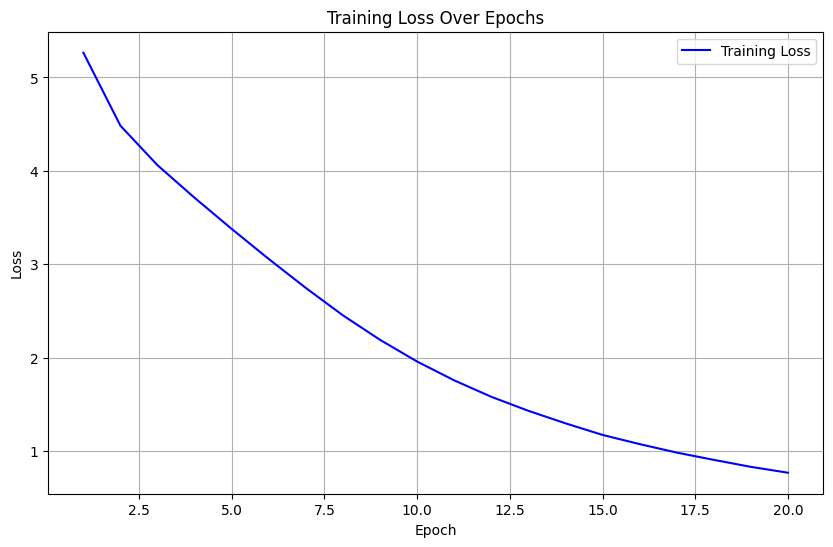

In [45]:
# Vẽ biểu đồ loss
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), losses, 'b-', label='Training Loss')
plt.title('Training Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()
plt.savefig(os.path.join(log_dir, 'training_loss_plot.png'))

In [46]:
import matplotlib.pyplot as plt
import networkx as nx
from matplotlib.patches import FancyArrowPatch

# Create a directed graph
G = nx.DiGraph()

# Define nodes with labels and shapes
nodes = [
    ("Image Features\n(batch_size, 1, 1024)", "input"),
    ("Image Features\n(batch_size, 1024)", "process"),
    ("Image Encoded\n(batch_size, 512)", "process"),
    ("Questions\n(batch_size, max_question_len)", "input"),
    ("Question Embedded\n(batch_size, max_question_len, 256)", "process"),
    ("Question Hidden\n(1, batch_size, 512)", "process"),
    ("Question Encoded\n(batch_size, 512)", "process"),
    ("Combined\n(batch_size, 1024)", "process"),
    ("Combined Features\n(batch_size, max_answer_len, 1024)", "process"),
    ("Decoder Output\n(batch_size, max_answer_len, 512)", "process"),
    ("Outputs\n(batch_size, max_answer_len, answer_vocab_size)", "output")
]

# Add nodes to the graph
for i, (label, node_type) in enumerate(nodes):
    G.add_node(i, label=label, node_type=node_type)

# Define edges with labels
edges = [
    (0, 1, "Squeeze"),
    (1, 2, "Linear (1024→512)\nReLU"),
    (3, 4, "Embedding\n(30→256)"),
    (4, 5, "LSTM\n(256→512)"),
    (5, 6, "Squeeze"),
    (2, 7, ""),
    (6, 7, ""),
    (7, 8, "Unsqueeze\nRepeat"),
    (8, 9, "LSTM\n(1024→512)"),
    (9, 10, "Linear\n(512→answer_vocab_size)")
]

# Add edges to the graph
for src, dst, label in edges:
    G.add_edge(src, dst, label=label)

# Define positions for a layered layout
pos = {
    0: (0, 4),    # Image Features (input)
    1: (1, 4),    # Image Features (squeezed)
    2: (2, 4),    # Image Encoded
    3: (0, 2),    # Questions (input)
    4: (1, 2),    # Question Embedded
    5: (2, 2),    # Question Hidden
    6: (3, 2),    # Question Encoded
    7: (3, 3),    # Combined
    8: (4, 3),    # Combined Features
    9: (5, 3),    # Decoder Output
    10: (6, 3)    # Outputs
}

# Create figure
plt.figure(figsize=(14, 8))

# Draw nodes with different colors based on type
node_colors = {
    "input": "#a3e635",    # Green for inputs
    "process": "#42a5f5",  # Blue for processing
    "output": "#ef5350"    # Red for output
}

for node, data in G.nodes(data=True):
    nx.draw_networkx_nodes(
        G, pos, nodelist=[node],
        node_color=node_colors[data["node_type"]],
        node_shape="s", node_size=4000,
        edgecolors="#333333", linewidths=2
    )

# Draw edges
for src, dst, data in G.edges(data=True):
    # Create a curved arrow
    arrow = FancyArrowPatch(
        pos[src], pos[dst],
        connectionstyle="arc3,rad=0.1",
        arrowstyle="->", color="#555555",
        mutation_scale=20, linewidth=2
    )
    plt.gca().add_patch(arrow)

# Draw node labels
node_labels = {i: data["label"] for i, data in G.nodes(data=True)}
nx.draw_networkx_labels(G, pos, labels=node_labels, font_size=8, font_weight="bold")

# Draw edge labels
edge_labels = {(src, dst): data["label"] for src, dst, data in G.edges(data=True)}
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=7)

# Customize plot
plt.title("VQA Model Architecture", fontsize=16, pad=20)
plt.axis("off")  # Hide axes
plt.tight_layout()

# Save and show the plot
plt.savefig("vqa_model_architecture.png", dpi=300, bbox_inches="tight")
plt.close()

Question: cuốn sách này nói về lịch_sử của gì ?
Predicted Answer: <sos> các nền văn_minh <eos> và <eos> <eos> <eos> <eos>
Actual: các nền văn_minh


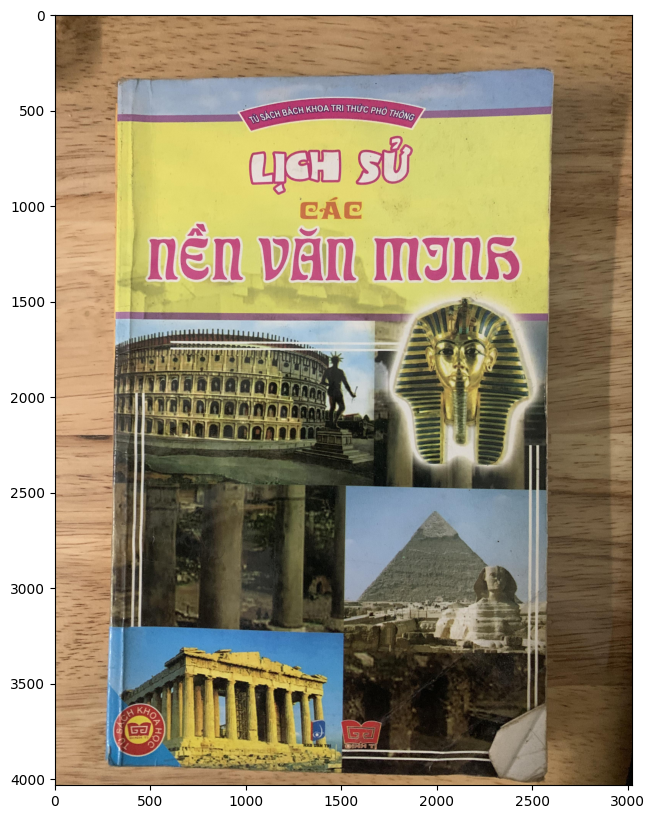

In [47]:
# Ví dụ dự đoán
sample_row = df_all.iloc[16]
image_id = str(sample_row['image_id'])
question = sample_row['question']
answer = sample_row['answers']
image = Image.open(sample_row['path'])
plt.figure(figsize= (20, 10))
plt.imshow(image)
predicted_answer = predict_answer(model, features[image_id], question, vocab_questions, vocab_answers, len_max_question, device)
print(f"Question: {question}")
print(f"Predicted Answer: {predicted_answer}")
print(f"Actual: {answer}")

In [48]:
from nltk.translate.bleu_score import sentence_bleu
from rouge_score import rouge_scorer

scorer = rouge_scorer.RougeScorer(['rouge1', 'rougeL'], use_stemmer=True)
reference = sample_row['answers']
score = scorer.score(reference, predicted_answer)
bleu_score = sentence_bleu([spacy_tokenizer(reference)], spacy_tokenizer(predicted_answer))
print(f"ROUGE: {score}")
print(f"BLEU: {bleu_score}")

ROUGE: {'rouge1': Score(precision=0.5, recall=1.0, fmeasure=0.6666666666666666), 'rougeL': Score(precision=0.5, recall=1.0, fmeasure=0.6666666666666666)}
BLEU: 1.9496467388840193e-78


/usr/local/lib/python3.11/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
